# COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization (Group 17)


(Semester 2, 2023)

In this ipython notebook, we provide some example code for loading data and evaluation for assignment1.

Load Data.
- ORL dataset.
- Extended YaleB dataset.

Perform Evaluation.
- Root Means Square Errors (RMSE).
- Accuracy, NMI.

Lecturers: Dr. Imdad Ullah

Tutors: Jaime Ruiz Serra, Yuchen Shen, Daniel Friedrich, Rafiul Nakib, Siyu Xu, Yongpei (Michael) Ma

Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).

### 1. Load Dataset

#### 1.1 Load ORL Dataset and Extended YaleB Dataset.
- ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

- Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [2]:
import os
import numpy as np
from PIL import Image
from numpy import sqrt
import warnings
warnings.filterwarnings("ignore")

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load ORL dataset.
X_hat_o, Y_hat_o = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat_o.shape, Y_hat_o.shape))

# Load Extended YaleB dataset.
X_hat_y, Y_hat_y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat_y.shape, Y_hat_y.shape))

ORL dataset: X_hat.shape = (2576, 400), Y_hat.shape = (400,)
Extended YalB dataset: X_hat.shape = (2016, 2414), Y_hat.shape = (2414,)


### 2.1 add noise

In [4]:
img_size = [i//4 for i in (168, 192)] # YaleB
X_hat_y1=X_hat_y
'''noise size 10'''
X=[]
for ind in range(X_hat_y.shape[1]):
    img_m = X_hat_y[:,ind].reshape(img_size[1],img_size[0])

    L, W = img_m.shape[0], img_m.shape[1]
    Length = np.random.randint(0, L - 10 + 1)
    width = np.random.randint(0, W - 10 + 1)


    img_m[Length:Length+10, width:width+10] = 255
    X.append(img_m.reshape(X_hat_y.shape[0],))
X_Yale1=np.array(X).T
'''noise size 14'''
X=[]
X_hat_y, Y_hat_y = load_data('data/CroppedYaleB', reduce=4)
for ind in range(X_hat_y.shape[1]):
    img_m = X_hat_y[:,ind].reshape(img_size[1],img_size[0])

    L, W = img_m.shape[0], img_m.shape[1]
    Length = np.random.randint(0, L - 14 + 1)
    width = np.random.randint(0, W - 14 + 1)


    img_m[Length:Length+14, width:width+14] = 255
    X.append(img_m.reshape(X_hat_y.shape[0],))
X_Yale2=np.array(X).T

==> Load YaleB dataset ...
X_hat.shape=(2016, 2414), Y_hat.shape=(2414,)


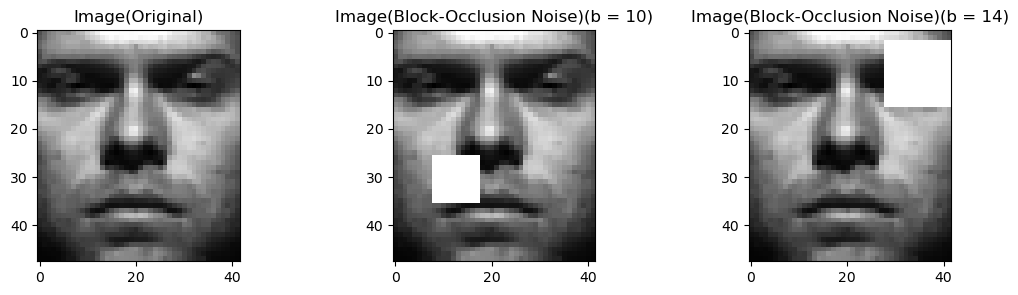

In [7]:
# Load dataset.
print('==> Load YaleB dataset ...')
X_hat_y, Y_hat_y = load_data('data/CroppedYaleB', reduce=4)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat_y.shape, Y_hat_y.shape))

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//4 for i in (168, 192)] # YaleB
ind = 2 # index of demo image.
plt.figure(figsize=(13,3))
plt.subplot(131)
plt.imshow(X_hat_y[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(X_Yale1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Block-Occlusion Noise)(b = 10)')
plt.subplot(133)
plt.imshow(X_Yale2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Block-Occlusion Noise)(b = 14)')
plt.show()

In [8]:
img_size = [i//2 for i in (92, 112)] # YaleB
'''noise size 10'''
X=[]
for ind in range(X_hat_o.shape[1]):
    img_m = X_hat_o[:,ind].reshape(img_size[1],img_size[0])

    L, W = img_m.shape[0], img_m.shape[1]
    Length = np.random.randint(0, L - 10 + 1)
    width = np.random.randint(0, W - 10 + 1)


    img_m[Length:Length+10, width:width+10] = 255
    X.append(img_m.reshape(X_hat_o.shape[0],))
X_ORL1=np.array(X).T

'''noise size 14'''
X_hat_o, Y_hat_o = load_data(root='data/ORL', reduce=2)

X=[]
for ind in range(X_hat_o.shape[1]):
    img_m = X_hat_o[:,ind].reshape(img_size[1],img_size[0])

    L, W = img_m.shape[0], img_m.shape[1]
    Length = np.random.randint(0, L - 14 + 1)
    width = np.random.randint(0, W - 14 + 1)


    img_m[Length:Length+14, width:width+14] = 255
    X.append(img_m.reshape(X_hat_o.shape[0],))
X_ORL2=np.array(X).T

==> Load ORL dataset ...
X_hat.shape=(2016, 2414), Y_hat.shape=(2414,)


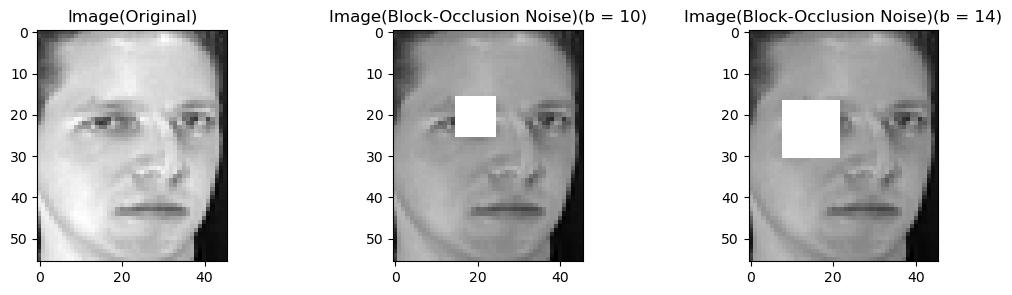

In [10]:
print('==> Load ORL dataset ...')
X_hat_o, Y_hat_o = load_data(root='data/ORL', reduce=2)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat_y.shape, Y_hat_y.shape))

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//2 for i in (92, 112)]
ind = 2 # index of demo image.
plt.figure(figsize=(13,3))
plt.subplot(131)
plt.imshow(X_hat_o[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(X_ORL1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Block-Occlusion Noise)(b = 10)')
plt.subplot(133)
plt.imshow(X_ORL2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Block-Occlusion Noise)(b = 14)')
plt.show()

### 3.1 Deploy NMF algorithms

Apply simple Norm NMF, L1 Norm NMF and L2,1-Norm NMF to the YaleB data set and two block-occlusion noises with different b values.

In [11]:
# set n_components to num_classes
from sklearn.metrics import mean_squared_error
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from model import unit as model
X_hat_y_norm = X_hat_y
Y_hat_y_norm = Y_hat_y
unit1=model.unit(X_hat_y_norm,Y_hat_y_norm)

n_components = len(set(Y_hat_y))
rng = np.random.RandomState(1)
'''Yale'''
'''---simple Norm NMF---'''
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_Yale0, Q_estimate_Yale0,simple_rmse_l_Yale0,simple_acc_Yale0,simple_nmi_Yale0 = unit1.mf_multiplicative_update(X_hat_y, P, Q)
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_Yale1, Q_estimate_Yale1,simple_rmse_l_Yale1,simple_acc_Yale1,simple_nmi_Yale1 = unit1.mf_multiplicative_update(X_Yale1, P, Q)
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_Yale2, Q_estimate_Yale2,simple_rmse_l_Yale2,simple_acc_Yale2,simple_nmi_Yale2 = unit1.mf_multiplicative_update(X_Yale2, P, Q)

'''---L1 Norm NMF---'''
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_l1_Yale0, Q_estimate_l1_Yale0,l1_rmse_Yale0,l1_acc_Yale0,l1_nmi_Yale0 = unit1.l1_norm_nmf(X_hat_y, P, Q)
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_l1_Yale1, Q_estimate_l1_Yale1,l1_rmse_Yale1,l1_acc_Yale1,l1_nmi_Yale1 = unit1.l1_norm_nmf(X_Yale1, P, Q)
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_l1_Yale2, Q_estimate_l1_Yale2,l1_rmse_Yale2,l1_acc_Yale2,l1_nmi_Yale2 = unit1.l1_norm_nmf(X_Yale2, P, Q)

'''---L2,1-Norm NMF---'''
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_l21_Yale0,Q_estimate_l21_Yale0,l21_rmse_Yale0,l21_acc_Yale0,l21_nmi_Yale0 =unit1.l21_multiplicative_update(X_hat_y ,P, Q.T)
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_l21_Yale1,Q_estimate_l21_Yale1,l21_rmse_Yale1,l21_acc_Yale1,l21_nmi_Yale1 =unit1.l21_multiplicative_update(X_Yale1 ,P, Q.T)
P = rng.rand(len(X_hat_y), n_components)
Q = rng.rand(len(X_hat_y[0]), n_components)
P_estimate_l21_Yale2,Q_estimate_l21_Yale2,l21_rmse_Yale2,l21_acc_Yale2,l21_nmi_Yale2 =unit1.l21_multiplicative_update(X_Yale2 ,P, Q.T)


Simple Norm NMF, L1 Norm NMF and L2,1-Norm NMF are applied to the ORL dataset.

In [12]:
unit2=model.unit(X_hat_o,Y_hat_o)
n_components = len(set(Y_hat_o))
'''ORL'''
'''---simple Norm NMF---'''
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_ORL0, Q_estimate_ORL0,simple_rmse_l_ORL0,simple_acc_ORL0,simple_nmi_ORL0 = unit2.mf_multiplicative_update(X_hat_o, P, Q)
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_ORL1, Q_estimate_ORL1,simple_rmse_l_ORL1,simple_acc_ORL1,simple_nmi_ORL1 = unit2.mf_multiplicative_update(X_ORL1, P, Q)
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_ORL2, Q_estimate_ORL2,simple_rmse_l_ORL2,simple_acc_ORL2,simple_nmi_ORL2 = unit2.mf_multiplicative_update(X_ORL2, P, Q)
'''---L1 Norm NMF---'''
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_l1_ORL0, Q_estimate_l1_ORL0,l1_rmse_l_ORL0,l1_acc_ORL0,l1_nmi_ORL0 = unit2.mf_multiplicative_update(X_hat_o, P, Q)
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_l1_ORL1, Q_estimate_l1_ORL1,l1_rmse_l_ORL1,l1_acc_ORL1,l1_nmi_ORL1 = unit2.mf_multiplicative_update(X_ORL1, P, Q)
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_l1_ORL2, Q_estimate_l1_ORL2,l1_rmse_l_ORL2,l1_acc_ORL2,l1_nmi_ORL2 = unit2.mf_multiplicative_update(X_ORL2, P, Q)
'''---L2,1-Norm NMF---'''
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_l21_ORL0, Q_estimate_l21_ORL0,l21_rmse_l_ORL0,l21_acc_ORL0,l21_nmi_ORL0 = unit2.mf_multiplicative_update(X_hat_o, P, Q)
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_l21_ORL1, Q_estimate_l21_ORL1,l21_rmse_l_ORL1,l21_acc_ORL1,l21_nmi_ORL1 = unit2.mf_multiplicative_update(X_ORL1, P, Q)
P = rng.rand(len(X_hat_o), n_components)
Q = rng.rand(len(X_hat_o[0]), n_components)
P_estimate_l21_ORL2, Q_estimate_l21_ORL2,l21_rmse_l_ORL2,l21_acc_ORL2,l21_nmi_ORL2 = unit2.mf_multiplicative_update(X_ORL2, P, Q)


### 4.1 Evaluate Clustering Performance
1. Accuracy

    $Acc(Y, Y_{pred}) = \frac{1}{n}\sum_{i=1}^n 1\{Y_{pred(i)} == Y(i)\}$
2. Normalized Mutual Information (NMI).

    $NMI(Y, Y_{pred}) = \frac{2*I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}$
   
  Where $I(.,.)$ is mutual information and  $𝐻(⋅)$ is entropy.

In [22]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score


print('==> Evaluate Simple Acc and NMI ...')
print('           --YaleB--           ')
# Assign cluster labels.
print('==> no noise')
Y_pred = unit1.assign_cluster_label(Q_estimate_Yale0, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 10')
Y_pred = unit1.assign_cluster_label(Q_estimate_Yale1, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 14')
Y_pred = unit1.assign_cluster_label(Q_estimate_Yale2, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('            --ORL--            ')
# Assign cluster labels.
print('==> no noise')
Y_pred = unit2.assign_cluster_label(Q_estimate_ORL0, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 10')
Y_pred = unit2.assign_cluster_label(Q_estimate_ORL1, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 14')
Y_pred = unit2.assign_cluster_label(Q_estimate_ORL2, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

==> Evaluate Simple Acc and NMI ...
           --YaleB--           
==> no noise
Acc(NMI) = 0.1881 (0.2695)
==>noise size 10
Acc(NMI) = 0.1015 (0.0964)
==>noise size 14
Acc(NMI) = 0.0829 (0.0747)
            --ORL--            
==> no noise
Acc(NMI) = 0.7275 (0.8531)
==>noise size 10
Acc(NMI) = 0.3975 (0.5797)
==>noise size 14
Acc(NMI) = 0.2600 (0.4226)


In [23]:
print('==> Evaluate L1 Acc and NMI ...')
print('           --YaleB--           ')
# Assign cluster labels.
print('==> no noise')
Y_pred = unit1.assign_cluster_label(Q_estimate_l1_Yale0, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 10')
Y_pred = unit1.assign_cluster_label(Q_estimate_l1_Yale1, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 14')
Y_pred = unit1.assign_cluster_label(Q_estimate_l1_Yale2, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('            --ORL--            ')
# Assign cluster labels.
print('==> no noise')
Y_pred = unit2.assign_cluster_label(Q_estimate_l1_ORL0, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 10')
Y_pred = unit2.assign_cluster_label(Q_estimate_l1_ORL1, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 14')
Y_pred = unit2.assign_cluster_label(Q_estimate_l1_ORL2, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

==> Evaluate L1 Acc and NMI ...
           --YaleB--           
==> no noise
Acc(NMI) = 0.1703 (0.2240)
==>noise size 10
Acc(NMI) = 0.0944 (0.0944)
==>noise size 14
Acc(NMI) = 0.0841 (0.0730)
            --ORL--            
==> no noise
Acc(NMI) = 0.7025 (0.8409)
==>noise size 10
Acc(NMI) = 0.4350 (0.6178)
==>noise size 14
Acc(NMI) = 0.2375 (0.4143)


In [24]:
print('==> Evaluate L2,1-norm Acc and NMI ...')
print('           --YaleB--           ')
# Assign cluster labels.
print('==> no noise')
Y_pred = unit1.assign_cluster_label(Q_estimate_l21_Yale0.T, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 10')
Y_pred = unit1.assign_cluster_label(Q_estimate_l21_Yale1.T, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 14')
Y_pred = unit1.assign_cluster_label(Q_estimate_l21_Yale2.T, Y_hat_y)
acc = accuracy_score(Y_hat_y, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_y, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('            --ORL--            ')
# Assign cluster labels.
print('==> no noise')
Y_pred = unit2.assign_cluster_label(Q_estimate_l21_ORL0, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 10')
Y_pred = unit2.assign_cluster_label(Q_estimate_l21_ORL1, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
print('==>noise size 14')
Y_pred = unit2.assign_cluster_label(Q_estimate_l21_ORL2, Y_hat_o)
acc = accuracy_score(Y_hat_o, Y_pred)
nmi = normalized_mutual_info_score(Y_hat_o, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

==> Evaluate L2,1-norm Acc and NMI ...
           --YaleB--           
==> no noise
Acc(NMI) = 0.1686 (0.2495)
==>noise size 10
Acc(NMI) = 0.1007 (0.1148)
==>noise size 14
Acc(NMI) = 0.0899 (0.0932)
            --ORL--            
==> no noise
Acc(NMI) = 0.6800 (0.8347)
==>noise size 10
Acc(NMI) = 0.4000 (0.5724)
==>noise size 14
Acc(NMI) = 0.2275 (0.3996)


#### Visualization

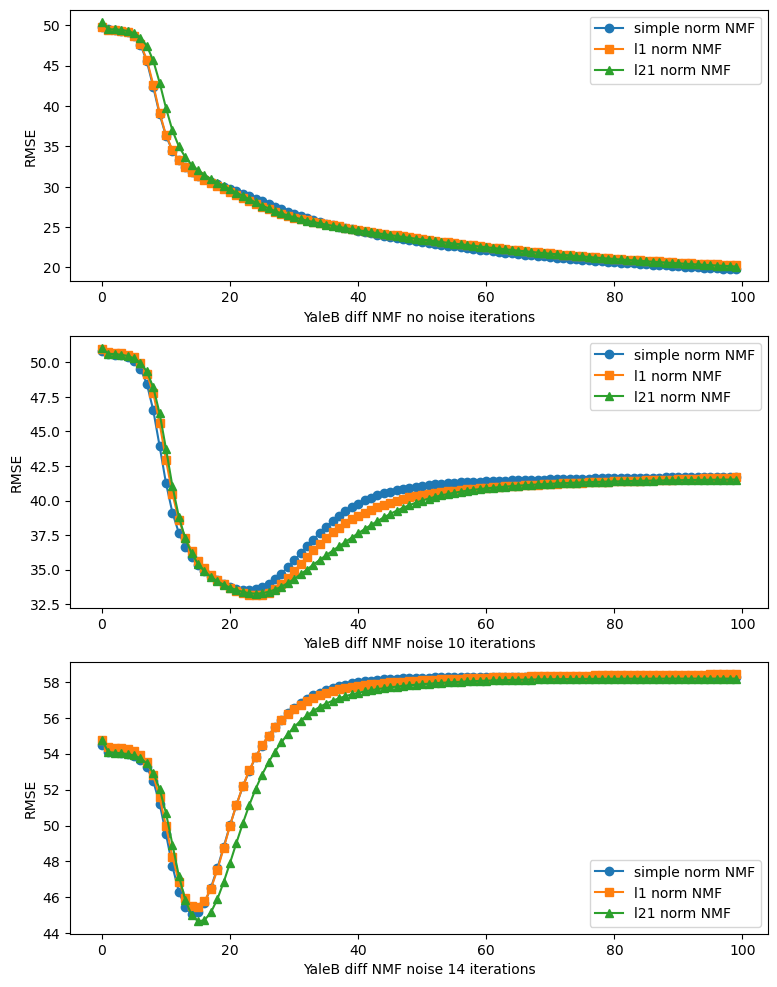

In [29]:
'''YaleB RMSE'''
fig = plt.figure(figsize=[9, 12])
iter_l = [i for i in range(0, 100)]
ax = fig.add_subplot(311)
ax.plot(iter_l, simple_rmse_l_Yale0, label='simple norm NMF', marker='o')
ax.plot(iter_l, l1_rmse_Yale0, label='l1 norm NMF', marker='s')
ax.plot(iter_l, l21_rmse_Yale0, label='l21 norm NMF', marker='^')
ax.set_xlabel('YaleB diff NMF no noise iterations')
ax.set_ylabel('RMSE')
ax.legend()
ax = fig.add_subplot(312)
ax.plot(iter_l, simple_rmse_l_Yale1, label='simple norm NMF', marker='o')
ax.plot(iter_l, l1_rmse_Yale1, label='l1 norm NMF', marker='s')
ax.plot(iter_l, l21_rmse_Yale1, label='l21 norm NMF', marker='^')
ax.set_xlabel('YaleB diff NMF noise 10 iterations')
ax.set_ylabel('RMSE')
ax.legend()
ax = fig.add_subplot(313)
ax.plot(iter_l, simple_rmse_l_Yale2, label='simple norm NMF', marker='o')
ax.plot(iter_l, l1_rmse_Yale2, label='l1 norm NMF', marker='s')
ax.plot(iter_l, l21_rmse_Yale2, label='l21 norm NMF', marker='^')
ax.set_xlabel('YaleB diff NMF noise 14 iterations')
ax.set_ylabel('RMSE')
ax.legend(loc='lower right')
plt.show()

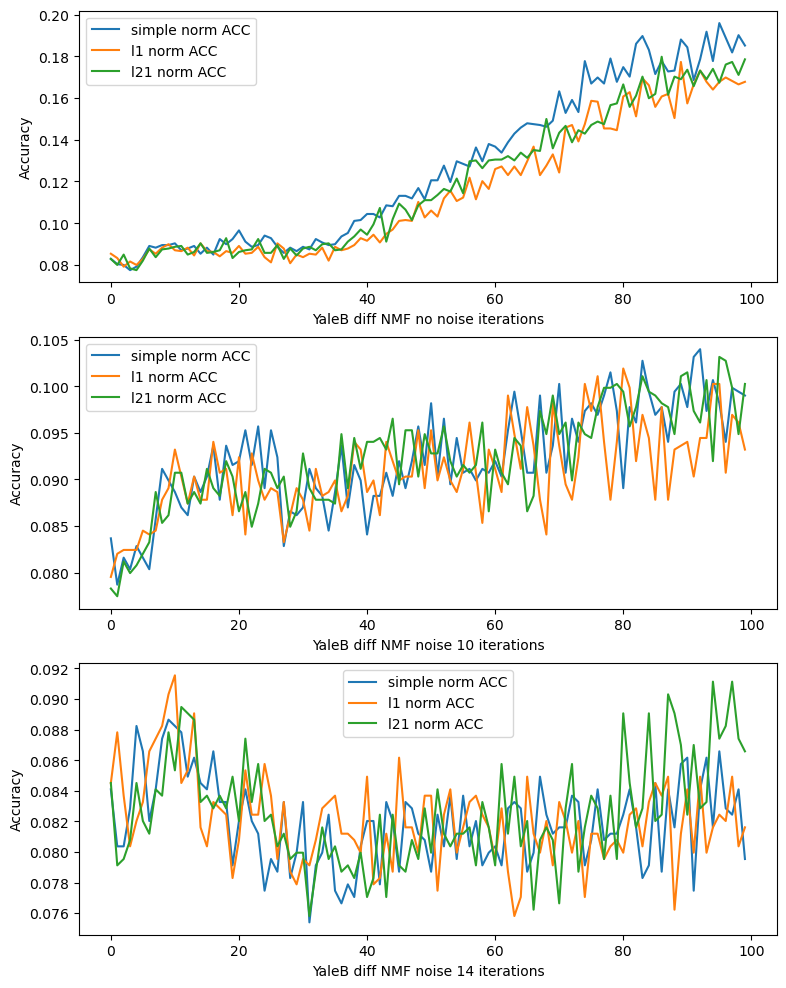

In [26]:
'''YaleB Accuracy'''
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
ax.plot(iter_l, simple_acc_Yale0, label='simple norm ACC')
ax.plot(iter_l, l1_acc_Yale0, label='l1 norm ACC')
ax.plot(iter_l, l21_acc_Yale0, label='l21 norm ACC')
ax.set_xlabel('YaleB diff NMF no noise iterations')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig.add_subplot(312)
ax.plot(iter_l, simple_acc_Yale1, label='simple norm ACC')
ax.plot(iter_l, l1_acc_Yale1, label='l1 norm ACC')
ax.plot(iter_l, l21_acc_Yale1, label='l21 norm ACC')
ax.set_xlabel('YaleB diff NMF noise 10 iterations')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig.add_subplot(313)
ax.plot(iter_l, simple_acc_Yale2, label='simple norm ACC')
ax.plot(iter_l, l1_acc_Yale2, label='l1 norm ACC')
ax.plot(iter_l, l21_acc_Yale2, label='l21 norm ACC')
ax.set_xlabel('YaleB diff NMF noise 14 iterations')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

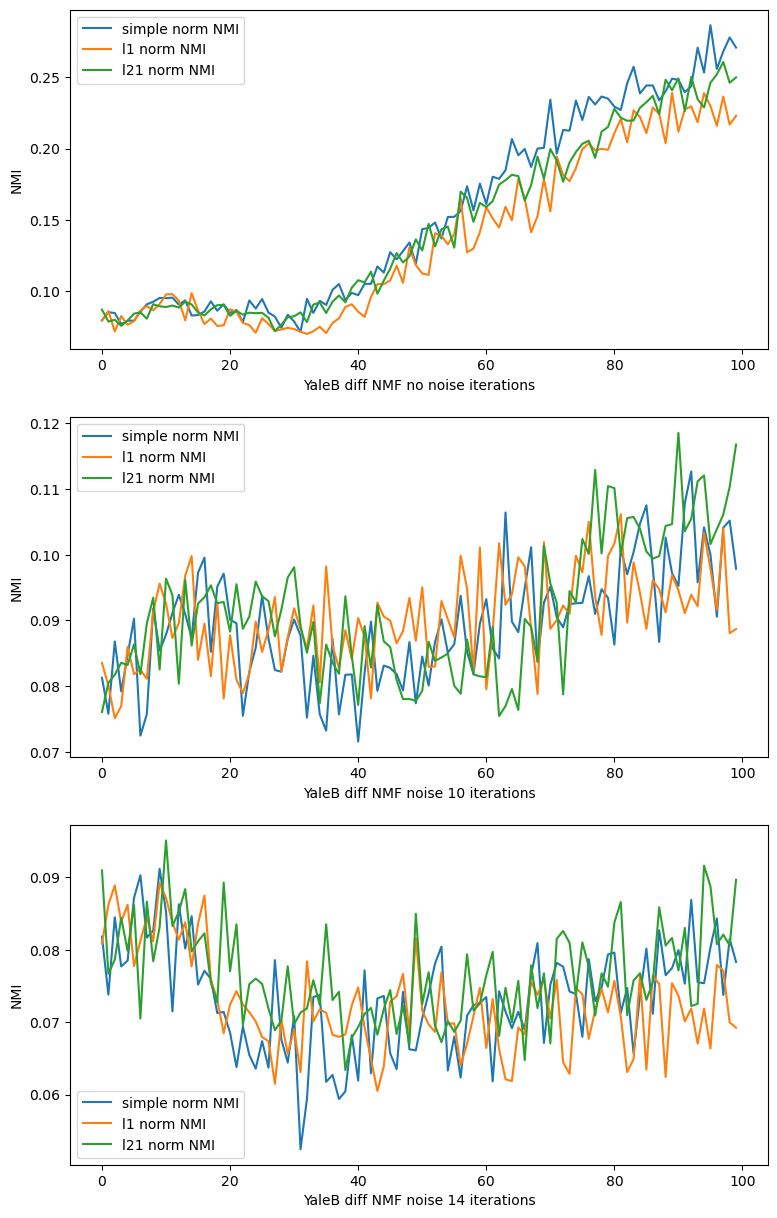

In [28]:
'''YaleB NMI'''
fig = plt.figure(figsize=[9, 15])

ax = fig.add_subplot(311)
ax.plot(iter_l, simple_nmi_Yale0, label='simple norm NMI')
ax.plot(iter_l, l1_nmi_Yale0, label='l1 norm NMI')
ax.plot(iter_l, l21_nmi_Yale0, label='l21 norm NMI')
ax.set_xlabel('YaleB diff NMF no noise iterations')
ax.set_ylabel('NMI')
ax.legend()
ax = fig.add_subplot(312)
ax.plot(iter_l, simple_nmi_Yale1, label='simple norm NMI')
ax.plot(iter_l, l1_nmi_Yale1, label='l1 norm NMI')
ax.plot(iter_l, l21_nmi_Yale1, label='l21 norm NMI')
ax.set_xlabel('YaleB diff NMF noise 10 iterations')
ax.set_ylabel('NMI')
ax.legend()
ax = fig.add_subplot(313)
ax.plot(iter_l, simple_nmi_Yale2, label='simple norm NMI')
ax.plot(iter_l, l1_nmi_Yale2, label='l1 norm NMI')
ax.plot(iter_l, l21_nmi_Yale2, label='l21 norm NMI')
ax.set_xlabel('YaleB diff NMF noise 14 iterations')
ax.set_ylabel('NMI')
ax.legend()
plt.show()

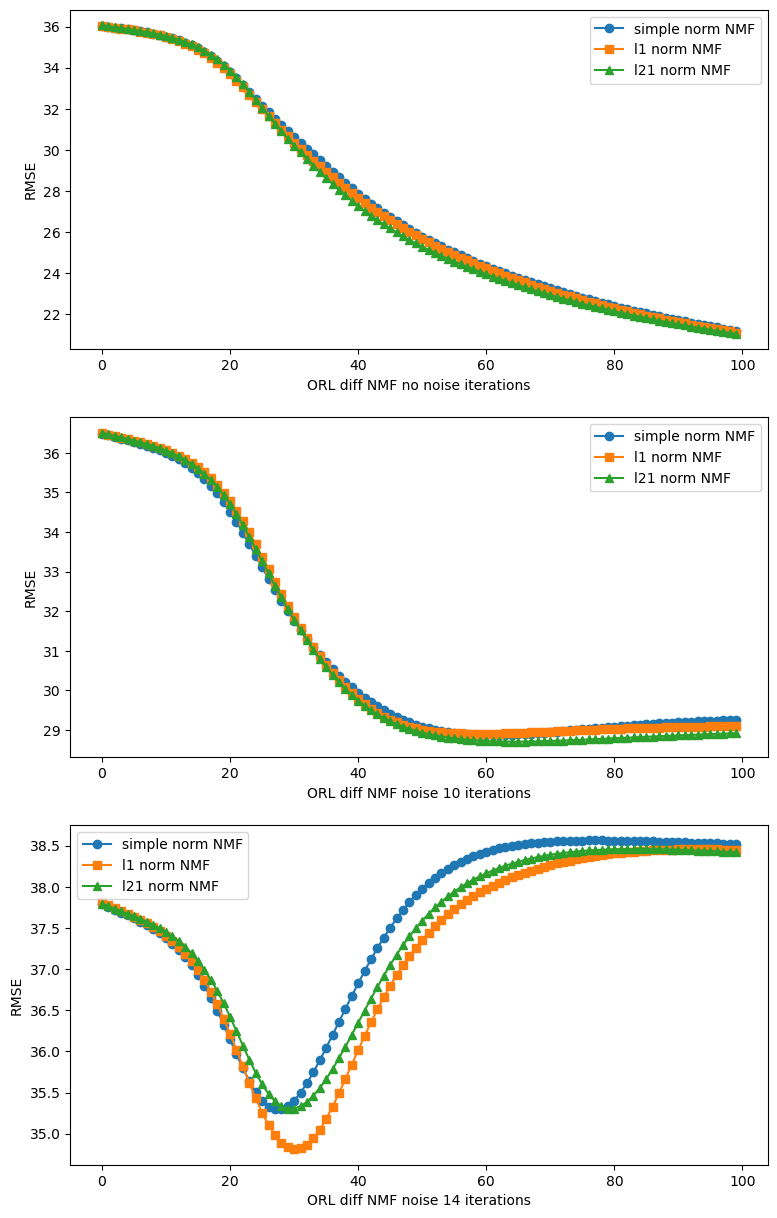

In [19]:
'''ORL RMSE'''
fig = plt.figure(figsize=[9, 15])
iter_l = [i for i in range(0, 100)]
ax = fig.add_subplot(311)
ax.plot(iter_l, simple_rmse_l_ORL0, label='simple norm NMF', marker='o')
ax.plot(iter_l, l1_rmse_l_ORL0, label='l1 norm NMF', marker='s')
ax.plot(iter_l, l21_rmse_l_ORL0, label='l21 norm NMF', marker='^')
ax.set_xlabel('ORL diff NMF no noise iterations')
ax.set_ylabel('RMSE')
ax.legend()
ax = fig.add_subplot(312)
ax.plot(iter_l, simple_rmse_l_ORL1, label='simple norm NMF', marker='o')
ax.plot(iter_l, l1_rmse_l_ORL1, label='l1 norm NMF', marker='s')
ax.plot(iter_l, l21_rmse_l_ORL1, label='l21 norm NMF', marker='^')
ax.set_xlabel('ORL diff NMF noise 10 iterations')
ax.set_ylabel('RMSE')
ax.legend()
ax = fig.add_subplot(313)
ax.plot(iter_l, simple_rmse_l_ORL2, label='simple norm NMF', marker='o')
ax.plot(iter_l, l1_rmse_l_ORL2, label='l1 norm NMF', marker='s')
ax.plot(iter_l, l21_rmse_l_ORL2, label='l21 norm NMF', marker='^')
ax.set_xlabel('ORL diff NMF noise 14 iterations')
ax.set_ylabel('RMSE')
ax.legend()
plt.show()

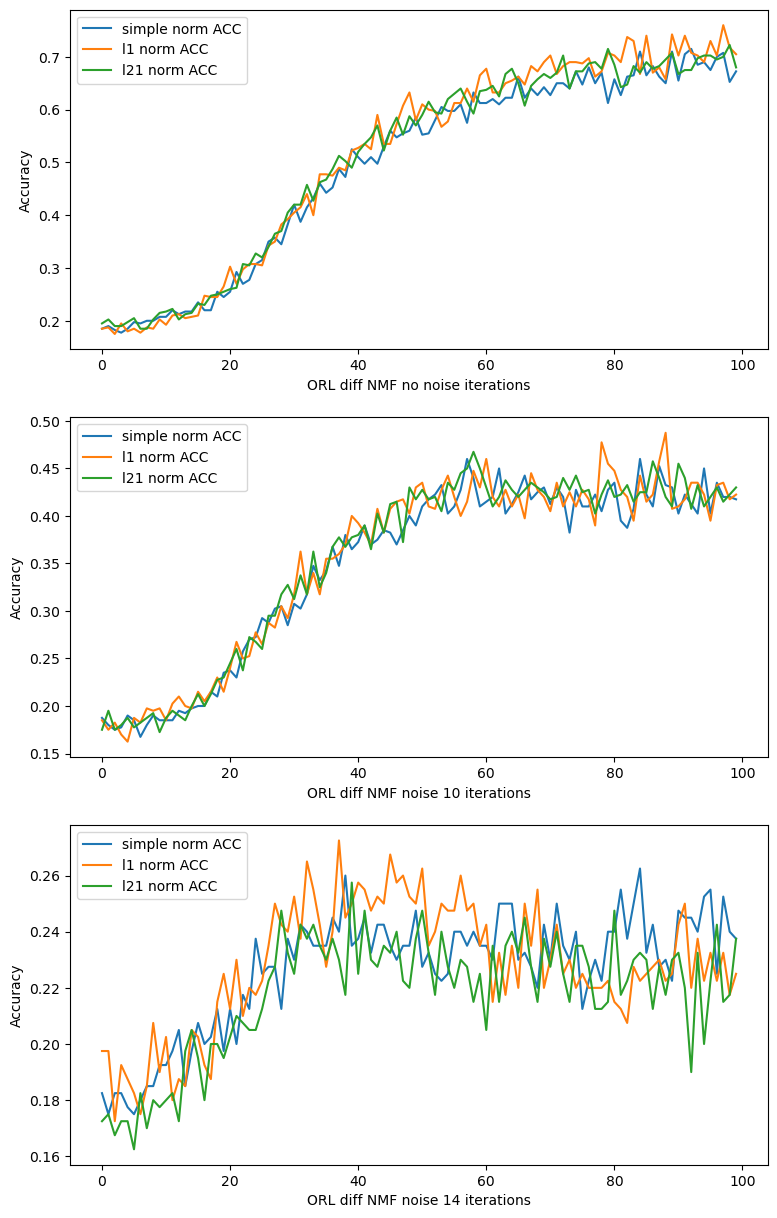

In [20]:
'''ORL Accuracy'''
fig = plt.figure(figsize=[9, 15])

ax = fig.add_subplot(311)
ax.plot(iter_l, simple_acc_ORL0, label='simple norm ACC')
ax.plot(iter_l, l1_acc_ORL0, label='l1 norm ACC')
ax.plot(iter_l, l21_acc_ORL0, label='l21 norm ACC')
ax.set_xlabel('ORL diff NMF no noise iterations')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig.add_subplot(312)
ax.plot(iter_l, simple_acc_ORL1, label='simple norm ACC')
ax.plot(iter_l, l1_acc_ORL1, label='l1 norm ACC')
ax.plot(iter_l, l21_acc_ORL1, label='l21 norm ACC')
ax.set_xlabel('ORL diff NMF noise 10 iterations')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig.add_subplot(313)
ax.plot(iter_l, simple_acc_ORL2, label='simple norm ACC')
ax.plot(iter_l, l1_acc_ORL2, label='l1 norm ACC')
ax.plot(iter_l, l21_acc_ORL2, label='l21 norm ACC')
ax.set_xlabel('ORL diff NMF noise 14 iterations')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

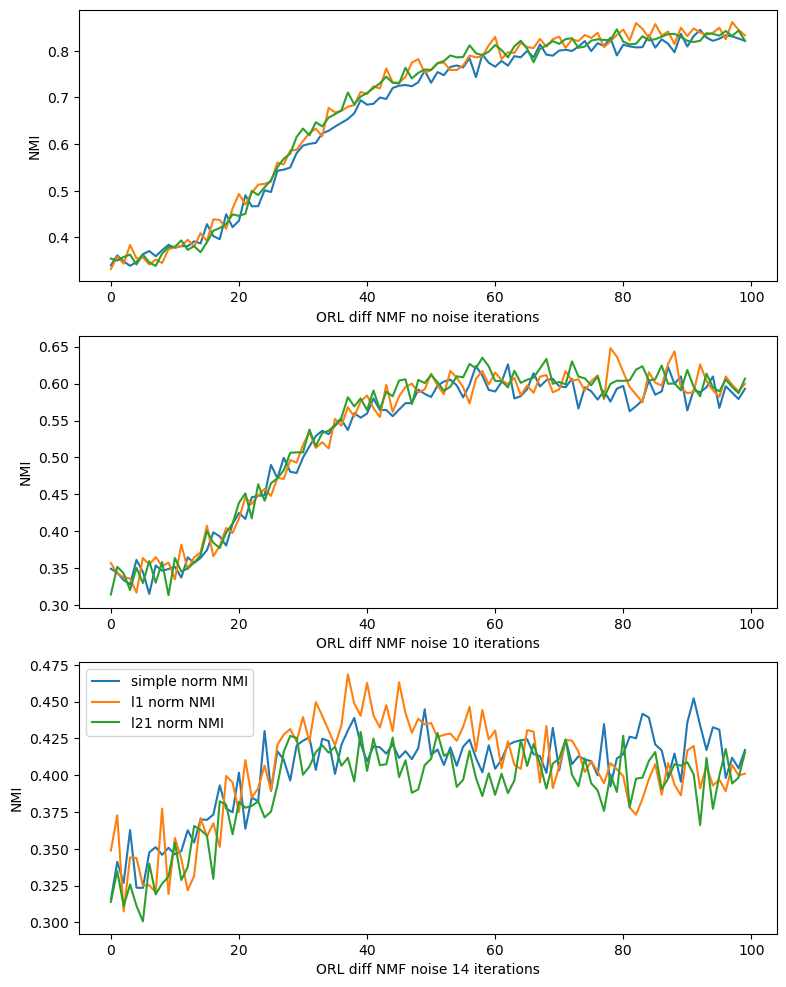

In [21]:
'''ORL NMI'''
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
ax.plot(iter_l, simple_nmi_ORL0, label='simple norm NMI')
ax.plot(iter_l, l1_nmi_ORL0, label='l1 norm NMI')
ax.plot(iter_l, l21_nmi_ORL0, label='l21 norm NMI')
ax.set_xlabel('ORL diff NMF no noise iterations')
ax.set_ylabel('NMI')
ax = fig.add_subplot(312)
ax.plot(iter_l, simple_nmi_ORL1, label='simple norm NMI')
ax.plot(iter_l, l1_nmi_ORL1, label='l1 norm NMI')
ax.plot(iter_l, l21_nmi_ORL1, label='l21 norm NMI')
ax.set_xlabel('ORL diff NMF noise 10 iterations')
ax.set_ylabel('NMI')
ax = fig.add_subplot(313)
ax.plot(iter_l, simple_nmi_ORL2, label='simple norm NMI')
ax.plot(iter_l, l1_nmi_ORL2, label='l1 norm NMI')
ax.plot(iter_l, l21_nmi_ORL2, label='l21 norm NMI')
ax.set_xlabel('ORL diff NMF noise 14 iterations')
ax.set_ylabel('NMI')
ax.legend()
plt.show()